In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from keras.models import load_model
from PIL import Image
import os
import random
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import interpolate

random.seed(42)
plt.style.use(['science', 'grid', 'no-latex'])  # 启用科学风格
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rc('font', family='Times New Roman')


In [2]:
# quetion 2.1
both = (1.24368897 + 1.19082498 + 1.36432628 + 1.3724841 + 3.3348852) / 5
rotate = (1.18564008 + 1.28830863 + 1.31178919 + 1.4818635 + 3.45269949) / 5
flipping = (2.01524496 + 1.24469714 + 2.09770827 + 1.72732041 + 4.35337071) / 5
neither = (5.02860929 + 2.34468264 + 5.38124013 + 3.89984033 + 9.15889678) / 5
print("both:{}, rotate:{}, flipping:{}, neither:{}".format(both, rotate, flipping, neither))

both:1.701241906, rotate:1.7440601780000002, flipping:2.287668298, neither:5.162653833999999


In [3]:
# 数据预处理
def process(train_y):
    print('process data\n')  # 服务器进度展示

    # y归一化到[0,1]
    train_max = np.max(train_y, axis=0)
    train_min = np.min(train_y, axis=0)
    for i in range(train_y.shape[1]):
        train_y[:, i] = (train_y[:, i] - train_min[i]) / (train_max[i] - train_min[i])

    return train_y


def load_data():
    print('load  data')
    ## 载入测试集的x
    count = -1
    final_test_data = np.zeros([344, 64, 64, 64, 1])
    for cycleTiff in range(357):
        filename = "/home/guozy/Ni-YSZ_CNN/predict/anode_stacks_15000/" + str(cycleTiff + 1) + ".tiff"
        if os.path.exists(filename) == False:
            continue
        count = count + 1
        img = Image.open(filename)
        for i in range(img.n_frames):  # 可以用img.n_frames来得到总页数
            try:
                img.seek(i)  # 是否存在
                final_test_data[count, :, :, i, 0] = img
            except EOFError:  # 页数读完了
                break

    # 载入测试集的y
    with open("/home/guozy/Ni-YSZ_CNN/predict/Results_15000_predict.txt", "r") as f:
        line = f.readline()
        label_list = []
        while line:
            num = list(map(float, line.split()))
            label_list.append(num)
            line = f.readline()
        f.close()
        final_test_label = np.array(label_list)

    return final_test_data, final_test_label


# 载入选择的模型
def get_model(name=None):
    if name == None:

        print('avaliable model:')
        print('-' * 10)
        filepath = '/home/guozy/Ni-YSZ_CNN/model/'
        subpath = os.listdir(filepath)
        count = -1
        for p in subpath:
            count += 1
            print('{},{}'.format(count, p))
        print('-' * 10)

        choice = int(input('input the number of the determined model\n'))
        filepath = filepath + subpath[choice] + '/model.h5'
        print('load model')
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    else:
        filepath = '/home/guozy/Ni-YSZ_CNN/model/' + name + '/model.h5'
        model = load_model(filepath, compile=False)  # 根据具体读取模型地址修改

    return model

# 载入数据并数据增强
def both(xi,choice):
    x_aug = np.zeros([1, 64, 64, 64, 1])  # 增强后的样本x
    
    # 分12种情况进行讨论
    if choice == 1:  # x轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i, 0], axis=0)

    elif choice == 2: # y轴为对称轴
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.flip(xi[:, :, i, 0], axis=1)

    elif choice == 3: # z轴为对称轴
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.flip(xi[i, :, :, 0], axis=1)
    
    elif choice == 4:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 1)

    elif choice == 5:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 2)

    elif choice == 6:
        for i in range(64):
            x_aug[0, i, :, :, 0] = np.rot90(xi[i, :, :, 0], 3)

    elif choice == 7:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 1)

    elif choice == 8:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 2)

    elif choice == 9:
        for i in range(64):
            x_aug[0, :, i, :, 0] = np.rot90(xi[:, i, :, 0], 3)

    elif choice == 10:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 1)

    elif choice == 11:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 2)

    elif choice == 12:
        for i in range(64):
            x_aug[0, :, :, i, 0] = np.rot90(xi[:, :, i, 0], 3)

    return x_aug # (1, 64, 64, 64, 1)


def aug_data(x, y):
    print('augment data in all ways\n')
    total = x.shape[0]  # 总共有多少幅图
    x_aug = np.zeros([total * 12, 64, 64, 64, 1],dtype=np.float32)  # 增强后的样本x
    y_aug = y

    for i in range(1,13): # 共12种方法
        for j in range(total): # 共total幅图
            xj = x[j, :, :, :, :]  # 得到第i个样本
            x_aug[(i-1) * total + j, :, :, :, :] = both(xj, i)
        y_aug= tf.concat([y_aug, y], axis=0)
    x_aug = tf.concat([x, x_aug], axis=0)

    return x_aug.numpy(), y_aug.numpy()

# 载入数据
test_x, test_y = load_data()
test_x, test_y = aug_data(test_x, test_y)

load  data
augment data in all ways



2023-04-12 23:12:32.643337: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 23:12:33.907379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22193 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d5:00.0, compute capability: 8.6
2023-04-12 23:12:33.909047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22301 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:f5:00.0, compute capability: 8.6


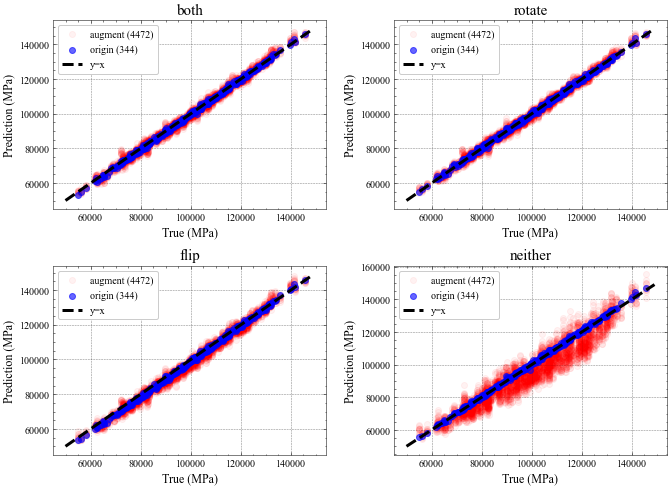

In [9]:
# 画实际-预测散点图
def show_mae_scatter(test_x, test_y):
    max_min_nor = np.array(
        [[1.65219166e+05, 4.88838187e+04], [2.84213381e-01, 2.07984799e-01], [6.37954456e+04, 1.68850886e+04],
         [1.58147200e-05, 1.19209400e-05], [1.34268741e+01, 4.93731340e+00]])

    plt.figure(figsize=(11, 8))
    for i in range(4):
        if i == 0:
            label = "both"
        elif i == 1:
            label = "rotate"
        elif i == 2:
            label = "flip"
        elif i == 3:
            label = "neither"
        model = get_model(label)
        plt.subplot(2, 2, i + 1)



        # 增强数据点的散点图
        pred_y = np.array(model.predict(test_x[344:, :, :, :, :]), dtype='float64')
        pred_y[:, 0] = pred_y[:, 0] * (max_min_nor[0, 0] - max_min_nor[0, 1]) + max_min_nor[0, 1]
        plt.scatter(test_y[344:, 0], pred_y[:, 0], alpha=0.05, c='r',label = 'augment (4472)')

        # 原始数据点的散点图
        pred_y = np.array(model.predict(test_x[0:344, :, :, :, :]), dtype='float64')
        pred_y[:, 0] = pred_y[:, 0] * (max_min_nor[0, 0] - max_min_nor[0, 1]) + max_min_nor[0, 1]
        plt.scatter(test_y[0:344, 0], pred_y[:, 0], alpha=0.6, c='b',label = 'origin (344)')

        # 画直线
        line = range(50000,150000,1000)
        plt.plot(line,line,color = 'k',linestyle='--',linewidth=3,label='y=x')

        plt.title(label,fontsize=15)
        plt.xlabel('True (MPa)',{'size':12})
        plt.ylabel('Prediction (MPa)',{'size':12})
        plt.legend()
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)
    # plt.suptitle('Scatter Plot of E ranges from 4 types of Train Data to 2 types of Test Data ', fontsize=17, x=0.53, y=0.95)  # 添加标题
    plt.savefig("/home/guozy/Ni-YSZ_CNN/Figure_4.jpg", dpi=500)

show_mae_scatter(test_x, test_y)